# Aprendizaje No Supervisado

In [1]:
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
# Creating the data
x1 = np.array([3, 1, 1, 2, 1, 6, 6, 6, 5, 6, 10, 12, 5, 7, 12, 7, 8, 9, 8, 1, 9, 10, 9, 9, 8])
x2 = np.array([5, 4, 5, 6, 5, 8, 6, 7, 6, 7, 1, 2, 10,5,8,1,1,5,9,1,1, 2, 3, 2, 3])
X = np.array(list(zip(x1, x2))).reshape(len(x1), 2)

## Clustering

In [3]:
from sklearn.cluster import KMeans
# from sklearn import metrics
# from scipy.spatial.distance import cdist

# distortions = []
inertias = []
K = range(1, 10)
  
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
  
    # distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
    #                                     'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)

### Número óptimo de clusters:

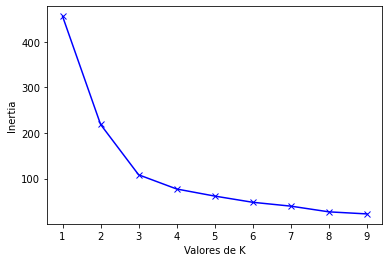

In [4]:
# plt.figure()    
# plt.plot(K, distortions, 'bx-')
# plt.xlabel('Valor de K')
# plt.ylabel('Distortion')
# plt.show()

plt.figure()
plt.plot(K, inertias, 'bx-')
plt.xlabel('Valores de K')
plt.ylabel('Inertia')
plt.show()

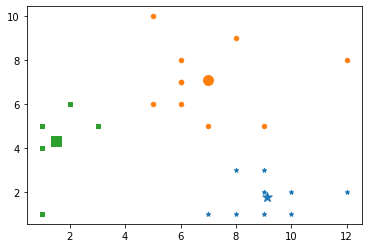

In [5]:
# Clustering con k determinada (Elbow)
k=3
kmeanModel = KMeans(n_clusters=k).fit(X)
kmeanModel.fit(X)
mark=['*','o','s','+','x','H','^']
fig, ax = plt.subplots()
for ki in range(k):
    p = ax.scatter(kmeanModel.cluster_centers_[ki,:][0],kmeanModel.cluster_centers_[ki,:][1],marker=mark[ki],s=100)
    ax.scatter(X[kmeanModel.labels_==ki,0],X[kmeanModel.labels_==ki,1],color=p.get_facecolor(),marker=mark[ki],s=20)

# Datos más complejos

In [6]:

from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import torchvision.transforms as T

In [7]:
BATCH_SIZE=256 #max 13878
IMAGE_SIZE = (128,128)

train_transforms = T.Compose([T.Grayscale(),
                                 T.RandomHorizontalFlip(p=0.5),
                                 T.RandomVerticalFlip(p=0.5),
                                 T.Resize(size=IMAGE_SIZE),
                                 T.ToTensor()])

# Creamos los objetos datasets a partir de un ImageFolder de torchvision:
data_train = ImageFolder('../data/Variedades-JPG/ENTRENAMIENTO_45_GREYSCALE', transform=train_transforms) # /content/data
train_loader = DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

# Mostramos el batch de entrenamiento:
print(f'Encontradas {len(data_train.classes)} clases: {data_train.class_to_idx}')
images, labels = next(iter(train_loader))
print(f'Tamaño de images: {images.shape}')
#plt.imshow(make_grid(images).permute(1, 2, 0)) 

Encontradas 7 clases: {'Arbequina': 0, 'Arbosana': 1, 'Changlot': 2, 'Lechin': 3, 'Ocal': 4, 'Picual': 5, 'Verdial': 6}
Tamaño de images: torch.Size([256, 1, 128, 128])


## Reducción de dimensión lineal con PCA


In [8]:
from sklearn.decomposition import PCA

data_pca = images.reshape((len(images), -1))
decom = PCA(n_components=2)
X = decom.fit_transform(data_pca)


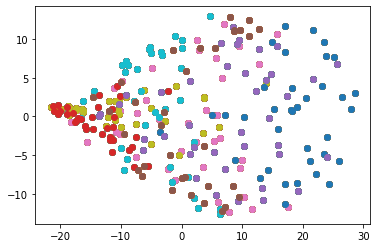

In [9]:
fig, ax = plt.subplots()
for l in labels:
    ax.scatter(X[labels==l,0], X[labels==l,1], label=l)

## Reducción de dimensión con Autoencoders

In [22]:
import torch
import torch.nn as nn
from torch import optim

class Autoencoder(nn.Module):
  def __init__(self):
    super(Autoencoder, self).__init__() # esta linea es siempre necesaria
    self.encoder = nn.Sequential(nn.Conv2d(1, out_channels=32, kernel_size=7, stride=2, padding=3),
                                  nn.ReLU(),
                                  nn.BatchNorm2d(32),
                                  nn.Conv2d(32, out_channels=128, kernel_size=5, stride=2, padding=2),                                  
                                  nn.ReLU(),
                                  nn.BatchNorm2d(128),
                                  nn.Conv2d(128, out_channels=128, kernel_size=3, stride=2, padding=1),                                  
                                  nn.ReLU(),
                                  nn.AvgPool2d(16)
                                  )
    self.fc1 = nn.Linear(128,3)
    self.fc2 = nn.Linear(3, 128)
    self.fc3 = nn.Linear(128, 128*16*16)
    self.decoder = nn.Sequential(nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
                                 nn.ReLU(),
                                 nn.BatchNorm2d(128),
                                 nn.ConvTranspose2d(128, 32, kernel_size=5, stride=2, padding=2, output_padding=1),
                                 nn.ReLU(),
                                 nn.BatchNorm2d(32),
                                 nn.ConvTranspose2d(32, 1, kernel_size=7, stride=2, padding=3, output_padding=1),
                                 nn.ReLU(),
                                 nn.Conv2d(1, 1, 3, padding=1) 

    )
    
  def forward(self, x):
    x = self.encoder(x)
    x = x.squeeze()
    z = self.fc1(x)
    x = self.fc2(z)
    x = self.fc3(x)
    x = self.decoder(x.view((-1, 128, 16, 16)))
    return x, z

model = Autoencoder()
model(images)[0].shape

torch.Size([256, 1, 128, 128])

In [23]:
def train_ae(model, optimizer, loss_fn, N_EPOCHS=2, device='cpu', early_stop=False, prefix='model_aceitunas_1108'):
  train_history={'loss': [], 'acc': []}
  max_perf = 1e11
  for e in range(N_EPOCHS):
    train_loss = 0.0 # el loss en cada epoch de entrenamiento
    train_acc = 0.0 # el accuracy de cada epoch
    total_train=0

    for ims, lbs in train_loader:
      total_train += 1
      ims = ims.to(device) # pasamos a cuda
      lbs = lbs.to(device) # pasamos a cuda

      output, z = model(ims) # forward pass
      loss = loss_fn(output, ims)#+0.1*torch.randn_like(output, device=device)) # calculamos el loss
      loss.backward()# backward pass
      optimizer.step() # optimización 

      train_loss += loss # acumulación para mostrar
    ls_val = (train_loss/total_train).detach().cpu().numpy()
    if early_stop and (ls_val < max_perf):
      max_perf = ls_val
      torch.save(model, f'{prefix}_{e}e.mdl')
    train_history['loss'].append(ls_val)
    print(f'Epoch {e}: Loss: {train_loss/total_train}')
    
  return train_history

In [ ]:
model = Autoencoder()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device) # pasamos a cuda
optimizer = optim.Adam(model.parameters(), lr=3e-6)
loss_fn = nn.L1Loss(reduce='sum')
train_ae(model, optimizer, loss_fn, N_EPOCHS=100, device=device, early_stop=True, prefix="ae_aceitunas_1708")

In [ ]:
model = torch.load("ae_aceitunas_1708_retrain_24e.mdl")
optimizer = optim.SGD(model.parameters(), lr=1e-5)
loss_fn = nn.L1Loss(reduce='sum')
train_ae(model, optimizer, loss_fn, N_EPOCHS=100, device=device, early_stop=True, prefix="ae_aceitunas_1708_retrain_retrain")

In [37]:
model = torch.load('ae_aceitunas_1708_retrain_24e.mdl')

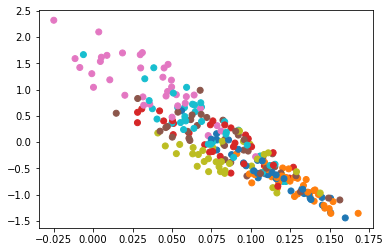

In [40]:
_, z = model.cpu()(images)
z = z.detach().cpu().numpy()
fig, ax = plt.subplots()
ax.scatter(z[:,2], z[:,1], c=labels, cmap='tab10')
# for l in labels:
#     ax.scatter(z[labels==l,0], z[labels==l,1], label=l)